In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from tqdm import tqdm as tqdm_botebook

plt.style.use('ggplot')
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. О котах и печеньках

В этой тетрадке мы посмотрим на данные одной мобильной игры под названием "Cookie Cats", разработанной компанией <a href="http://tactile.dk">Tactile Entertainment</a>. Это стандартный match-three пазл, где игрокам нужно соединять элементы одинаковых цветов, чтобы очистить поле и выиграть на уровне. И еще там есть поющие коты. Это важно.

<p><a href="https://youtu.be/GaP5f0jVTWE"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg" style="width: 500px"></a></p>

По мере того, как игроки проходят уровни, они встречают ворота-блокеры, которые вынуждают их либо ждать длительное время, либо совершить внутриигровую покупку, чтобы продолжить играть. Помимо того, что эти ворота приносят разработчикам деньги от покупок, они еще и вынуждают игроков делать перерыв, в надежде на то, что те вернутся с новыми силами и снова начнут получать удовольствие от котиков.

<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" alt=""></p>

Но возникает вопрос - когда и где ставить эти ворота? Изначально первые ворота стояли на 30-м уровне игры, однако в этом ноутбуке мы будем анализировать АБ-тест, в котором разработчики передвинули ворота на 40-й уровень. В частности мы будем смотреть влияние этого изменения на такой важный показатель как "retention" или удержание игроков, который расчитывается как отношение уникальных игроков, зашедших в игру на 1-й, 2-й, ... N-й день после установки ко всем игрокам, установившим приложение в этот день.

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DS12_2023/Ноутбуки/abData/cookie_cats.csv')
print(df.shape)
df.head()

(90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


__Описание колонок:__

- `userid` - уникальный номер, идентифицирующий каждого игрока.
- `version` - был ли пользователь отнесен к контрольной группе (`gate_30` - ворота на 30-м уровне) или к тестовой (`gate_40` - ворота на 40-м уровне).
- `sum_gamerounds` - число сессий, сыгранных игроком в течение первых 14 дней после установки игры.
- `retention_1` - вернулся ли игрок после __первого__ дня с момента установки?
- `retention_7` - вернулся ли игрок после __седьмого__ дня с момента установки?

Когда игрок устанавливает игру, он/она случайным образом относятся либо к группе `gate_30`, либо `gate_40`. На всякий случай, давайте проверим, действительно ли их примерно поровну в каждой из группу.

In [5]:
df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

# 2. Распределение числа игровых сессий

<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/mr_waffles_smiling.png" style="width:200px; float:left"> </p>
<p>Похоже, что игроков действительно примерно поровну в каждой из групп, отлично!</p>
<p>Фокус нашего анализа будет сосредоточен на удержании игроков (retention), но ради интереса давайте построим распределение числа игровых сессий, сыгранных игроками в течение их первой недели жизни в игре.</p>

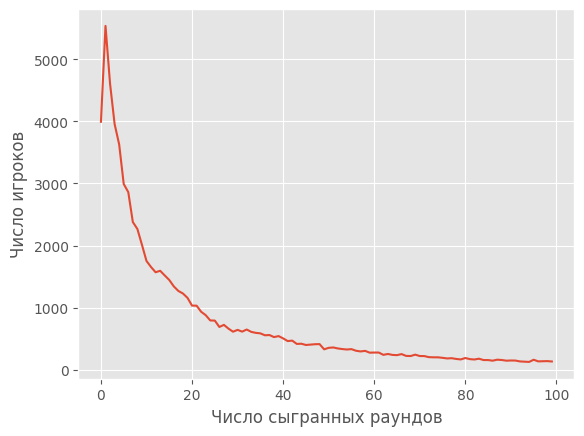

In [6]:
# Считаем число игроков, оставшееся в игре для каждого раунда
plot_df = df.groupby('sum_gamerounds')['userid'].count()

ax = plot_df.head(100).plot()
ax.set_xlabel("Число сыгранных раундов")
ax.set_ylabel("Число игроков");

<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/belle_cookie.png" style="width:200px; float:right"> </p>

На графике вверху мы видим, что некоторые игроки установили игру, но даже ни разу не поиграли (0 сессий), многие игроки закончили лишь пару сессий за первую неделю, а некоторые действительно подсели и сыграли более 80 раз!

Конечно, мы хотим, чтобы игроки были заинтересованы в игре и возвращались в неё снова и снова. Обычная метрика, использующаяся в игровой индустрии, чтобы измерить, насколько игра веселая и захватывающая, - это __удержание первого дня (1-day retention):__ Процент игроков, которые вренулись и снова стали играть спустя 1 день после установки. Чем выше удержание первого дня, тем проще и дальше удерживать пользователей и строить себе большую базу фанатов.

# 3. Удержание первого дня (1-day retention)

Посмотрим как выглядит удержание 1 дня.

In [7]:
df.retention_1.mean()

0.4452095044850259

А теперь по группам.

In [8]:
df.groupby('version').retention_1.mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

Похоже, что у нас есть небольшое ухудшение в удержании первого дня, если мы двигаем ворота к сороковому уровню (44.2%) в сравнеии с контрольной группой, где ворота остались на 30-м уровне (44.8%). Разница, конечно, невелика, но даже маленькие изменения в удержании могут иметь значительные последствия. Давайте проверим значимость этого эффекта. Будем использовать тест о равенстве долей.

$$
\begin{aligned}
&H_0: \hspace{2mm} p_{40} = p_{30} \\
&H_1: \hspace{2mm} p_{40} < p_{30}
\end{aligned}
$$

> **Предпосылки:** нет выбросов, много наблюдений. Наблюдения независимы. Тогда сможем использовать ЦПТ.

In [9]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05                    # уровень значимости = 5%

df_agg = df.groupby('version').retention_1.agg(['sum', 'count', 'mean'])
df_agg

,sum,count,mean
version,,,
gate_30,20034,44700,0.448188
gate_40,20119,45489,0.442283


In [10]:
n_obs = df_agg['count'].values  # размеры выборок
n_obs

array([44700, 45489])

In [11]:
m_obs = df_agg['sum'].values    # число успехов
p_obs = df_agg['mean'].values   # доли

z_obs, p_val =  proportions_ztest(m_obs,
                                  n_obs,
                                  value=0,
                                  alternative='larger')

print(f"Наблюдаемое значение статистики: {z_obs:.3}")
print(f"P-значение: {p_val:.3}")

Наблюдаемое значение статистики: 1.78
P-значение: 0.0372


Гипотеза о равенсве долей отвергается на $5\%$ уровне значимости. Посмотрим на оценку мощности этого эксперимента.

In [12]:
n_30, n_40 = n_obs  # размеры выборок
p_30, p_40 = p_obs  # доли

# дисперсии
var_40, var_30 = p_40 * (1 - p_40), p_30 * (1 - p_30)

# стандартизированный размер эффекта
effect = (p_30 - p_40) / ((n_40* np.sqrt(var_40) + n_30 * np.sqrt(var_30)) / (n_40 + n_30))
effect

0.01188210610259806

In [13]:
n_obs[1]/n_obs[0]

1.0176510067114093

In [14]:
from statsmodels.stats.power import zt_ind_solve_power

zt_ind_solve_power(effect_size=effect,
                   nobs1=sum(n_obs),
                   alpha=0.05,
                   power=None,
                   ratio=n_obs[1]/n_obs[0],
                   alternative='larger')

0.8131005106557109

# 4. Удержание седьмого дня (1-day retention)

Cпустя неделю после установки, уже больше игроков пройдут 40 уровней, поэтому имеет смысл посмотреть на удержание седьмого дня. Т.е., какой процент людей, установивших игру, снова показался в игре через 7 дней.

In [15]:
df.groupby('version').retention_7.mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Как и с 1-day retention, мы видим, что 7-day retention немного ниже (18.2%), когда ворота находятся на 40-м уровне, чем на 30-м (19.0%). Эта разница также выше, чем для удержания первого дня, скорее всего из-за того, что игроки имели больше времени на то, чтобы столкнуться с первыми воротами. Мы также видим, что удержание 7-го дня в целом ниже, чем удержание 1-го - спустя неделю намного меньше людей всё ещё заходит в игру. По-прежнему возикает вопрос: а значима ли эта разница.

In [16]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05                    # уровень значимости = 5%

df_agg = df.groupby('version').retention_7.agg(['sum', 'count', 'mean'])

n_obs = df_agg['count'].values  # размеры выборок
m_obs = df_agg['sum'].values    # число успехов
p_obs = df_agg['mean'].values   # доли

z_obs, p_val =  proportions_ztest(m_obs, n_obs, value=0, alternative='larger')

print(f"Наблюдаемое значение статистики: {z_obs:.3}")
print(f"P-значение: {p_val:.3}")

Наблюдаемое значение статистики: 3.16
P-значение: 0.000777


Видим, что разница сильно значима. Для 7-дневного удержания произойдёт довольно мощный обвал.

# 5.  Выводы

<p>Итак, результаты АБ-теста говорят нам о том, что есть значительное доказательство превышения 7-day retention в группе с воротами на 30-м уровне над группой с воротами на 40-м. Значит, если мы хотим поддерживать удержание клиентов на высоком уровне и иметь большее число игроков, нам <strong>не нужно</strong> сдвигать ворота с 30-го на 40-й уровень.


<p>Так почему же удержание выше, когда ворота расположены раньше? Логично было бы ожидать обратной ситуации - чем позже ставится препятствие, тем дольше игроки будут взаимодействовать с игрой. Однако это не то, что мы видим в данных. Теория гедонистической адаптации может помочь с объяснением. Если вкратце, гедонистическая адаптация - это тенденция получать всё меньше и меньше удовольствия от деятельности, если она продолжается длительное время. Заставляя игроков сделать паузу, когда они достигают 30-го уровня, мы продлеваем им удовольствие от игры, в результате чего они хотят в неё возвращаться. И напротив, сдвигая ворота к 40-му уровню мы даем игрокам возможность наиграться и просто заскучать.</p>

> __Вопрос:__ что мы сделали неправильно?

> __Ответ:__ при проведении эксперимента и проверке гипотезы мы никак не учитываем, что часть игроков вообще могла не дойти до ворот. Такие люди не остались в игре по каким-то иным причинам, не связанным с воротами. Если бы у нас были данные, связанные с этим, нам нужно было бы отфильтровать пользователей, которые не дошли в первый день до 30-го уровня.


<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_yellow.png" style="width:100px; float:center"> </p>